#Project MNIST Alphabets Prediction

### Connecting Gdrive to Colab

In [1]:
# This code connects colab to our Gdrive so that we can access files in our Drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# Unzipping the mnist.zip
!unzip /content/gdrive/MyDrive/project_cv/mnist.zip

# Importing Required Packages and Reading the extracted images

In [2]:
# Importing all required packages
from PIL import Image, ImageOps
import numpy as np
import os
from tqdm import tqdm
import pandas as pd

# Importing Packages for Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
# Opening one image from the extracted files
img = Image.open("/content/New_folder/A/A-0.png")

In [ ]:
# Checking the size of Image
img.size


(28, 28)

In [ ]:
# Opening and Checking the size of another Image
img2 = Image.open("/content/New_folder/F/F-1025.png")
img2.size


(28, 28)

* Reading all Extracted images
* Resizing the images to sizs(28,28) and converting to greyscale
* Flattening the image
* Appending all images to a list and converting to nparray

In [ ]:

data = []
labels = []
for i in os.listdir("/content/New_folder"):
    subdirectory = "/content/New_folder/" + i
    for j in tqdm(os.listdir(subdirectory), desc=f"Processing {i}"):
        filepath = subdirectory + "/" + j
        img = Image.open(filepath)
        img = img.resize((28,28)).convert("L")
        img = np.array(img).flatten().tolist()
        data.append(img)
        labels.append(i)
dat = np.asarray(data)

Processing H: 100%|██████████| 7218/7218 [00:02<00:00, 3464.96it/s]


###Converting the data into DataFrame and saving as csv file to Drive

In [ ]:
# Converting input and Output data to Dataframe
input= pd.DataFrame(dat).astype("uint8")
output = pd.DataFrame(labels,columns=["Labels"])

In [ ]:
# Saving the Dataframe to CSV
input.to_csv("input.csv")
output.to_csv("output.csv")

In [ ]:
# Merging input and output df to perform analysis
df = input.merge(output,left_index=True,right_index=True)

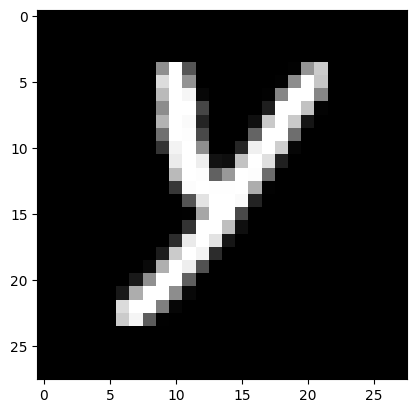

In [ ]:
# Converting the np array to image to show the image
img_2=np.asarray(input.iloc[0:1])
img_shape = (28, 28) 
img = np.reshape(img_2, img_shape)

plt.imshow(img, cmap='gray')
plt.show()


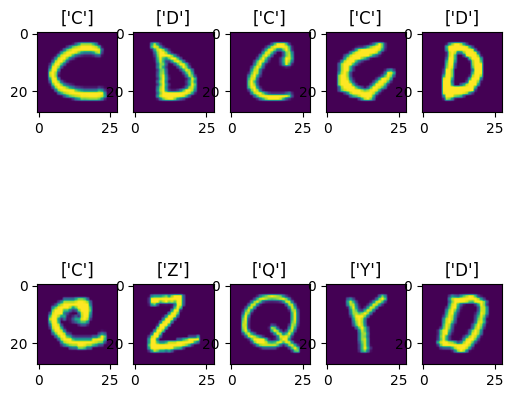

In [ ]:
# Randomly displaying images in the dataframe
random_n = np.random.randint(0,70000, size=(10,))
plt.figure(figsize=(6,6))
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.title(str((output.values[random_n[i-1]])))
    plt.imshow(input.iloc[random_n[i-1]].values.reshape(28,28))

#Data Analysis

In [ ]:
# Creating groupby for count of alphabets
count = df.groupby(["Labels"]).size().reset_index(name = "count")


In [ ]:
# Plotting Bar graph for count of letters
fig = px.bar(x=count["Labels"], y=count["count"],color=count["Labels"],hover_name=count["count"],width=700, height=400,\
            labels={'x':'Labels',"y":"count"})
fig.show()

* From the above plot it is seen that the data is unbalanced 
* O has the highest frequency with 57825
* I has the least frequency with 1120 

### Reading Input and Output data from CSV

* Reading the saved csv files and dropping unnecessary columns and changing datatype to "uint8"
* uint8 decreases the size of the dataframe

In [3]:

input = pd.read_csv("/content/gdrive/MyDrive/MNIST/input.csv").drop(["Unnamed: 0"],axis=1).astype("uint8")
output = pd.read_csv("/content/gdrive/MyDrive/MNIST/output.csv").drop(["Unnamed: 0"],axis=1)

# Splitting data into train and test for training the models

* Importing train_test_split and LabelEncoder from sklearn
* Splitting the data into Train and Test

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
# splitting data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(input,output,test_size=0.3,random_state=20)

## Installing cuml to train the models on GPU

* Installing cuml Package so that we can take advantage of GPU provided by colab to train and Predict 

In [ ]:
# Installing cuml package in oreder to train the models on gpu for faster output
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

In [ ]:
!pip uninstall -y pyarrow
!pip install pyarrow

* Importing cupy and cuml to train models on GPU

In [ ]:
import cupy as cp
import cuml

* converting Output columns to numeric using Labelencoder for training model in cuml

In [7]:
le = LabelEncoder()
Y_train_le = le.fit_transform(np.asarray(Y_train).ravel())
Y_test_le = le.fit_transform(np.asarray(Y_test).ravel())
#Y_train_decoded = le.inverse_transform(Y_train_le)
#Y_test_decoded = le.inverse_transform(Y_test_le)


In [8]:
# Converting  the data to cupy arrays for training models faster
X_train_gpu = cp.array(X_train)
X_test_gpu = cp.array(X_test)

X_train_cpu = cp.asnumpy(X_train_gpu)
X_test_cpu = cp.asnumpy(X_test_gpu)

* Creating a Function for Metrics and plotting Heatmap for Confusion Matrix

In [9]:
y_label = sorted(Y_train["Labels"].unique().tolist())
def metrics(test,pred,model,score=False,show_confusion_matrix=False):
    
    
    if score==True:
        acc = accuracy_score(test,pred)
        precision = precision_score(test,pred,average='weighted')
        recall = recall_score(test,pred,average='weighted')
        print(f"Accuracy of {model} Model is: {acc}\nPrecision of {model} Model is: {precision}\nRecall of {model} Model is: {recall}")
    
    elif show_confusion_matrix==True:
    
        plt.figure(figsize=(8,6))
        sns.set(font_scale=0.8)
        sns.heatmap(confusion_matrix(test, pred), xticklabels=y_label, yticklabels=y_label,cmap= 'Reds',linecolor='grey', linewidths=0.5,annot=True, fmt='d',annot_kws={"fontsize":5})
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.yticks(rotation=0)
        plt.title(f'Confusion Matrix for {model} Model')
        plt.show()

# Training Model using KNN Algorithm


In [ ]:
# Importing KNN classifier from cuml library
from cuml.neighbors import KNeighborsClassifier as cuKNeighbors

In [ ]:
# Importing Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import classification_report

In [ ]:
knn_cuml = cuKNeighbors()

In [ ]:
# Training the model using KNN
knn_cuml.fit(X_train,Y_train_le)

KNeighborsClassifier()

In [ ]:
# Predicting the Test data
y_pred_knn=knn_cuml.predict(X_test)

In [ ]:
# Checking for accuracy,Precision and Recall
metrics(test = Y_test_le,pred = y_pred_knn,model="KNN",score=True)


Accuracy of KNN Model is: 0.9568984033793942
Precision of KNN Model is: 0.9577012384284004
Recall of KNN Model is: 0.9568984033793942


In [ ]:
# classification report
print(classification_report(Y_test_le,y_pred_knn,target_names=y_label))

              precision    recall  f1-score   support

           A       0.94      0.97      0.96      4169
           B       0.98      0.86      0.91      2715
           C       0.94      0.98      0.96      7049
           D       0.94      0.87      0.90      3008
           E       0.98      0.91      0.94      3348
           F       0.96      0.90      0.93       386
           G       0.97      0.86      0.91      1718
           H       0.93      0.91      0.92      2204
           I       0.97      0.88      0.92       338
           J       0.93      0.91      0.92      2565
           K       0.94      0.91      0.92      1681
           L       0.92      0.98      0.95      3564
           M       0.98      0.96      0.97      3662
           N       0.95      0.98      0.96      5649
           O       0.95      0.99      0.97     17282
           P       0.90      0.98      0.94      5802
           Q       0.97      0.74      0.84      1757
           R       0.98    

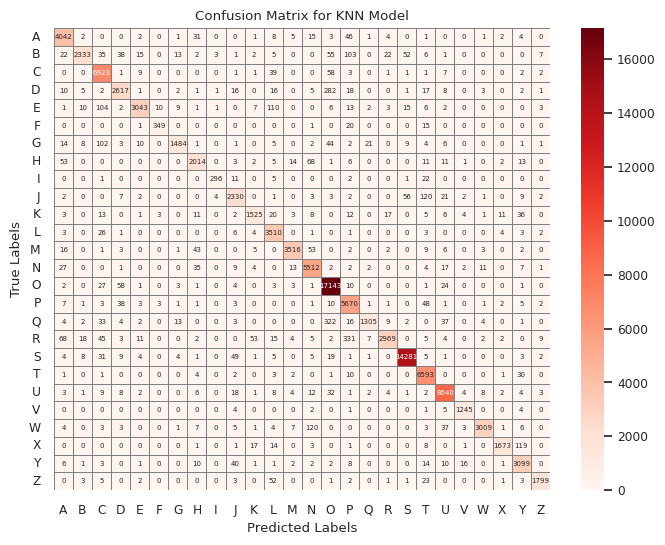

In [ ]:
# Heatmap of Confusion Matrix for KNN algorithm
metrics(test = Y_test_le,pred = y_pred_knn,model="KNN",show_confusion_matrix=True)


### Training Model Using DecisionTree Algorithm

In [ ]:
# Importing DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Training the Model
dt_gpu = DecisionTreeClassifier()
dt_gpu.fit(X_train_cpu,Y_train)


DecisionTreeClassifier()

In [ ]:
# Predicting test data
y_pred_dt = dt_gpu.predict(X_test_cpu)

In [ ]:
# Checking for accuracy,Precision and Recall

metrics(test = Y_test,pred = y_pred_dt,model="DecisionTree",score=True)


Accuracy of DecisionTree Model is: 0.9405384119710747
Precision of DecisionTree Model is: 0.9403275961101555
Recall of DecisionTree Model is: 0.9405384119710747


In [ ]:
print(classification_report(Y_test,y_pred_dt,target_names=y_label))


              precision    recall  f1-score   support

           A       0.91      0.91      0.91      4169
           B       0.90      0.86      0.88      2715
           C       0.96      0.97      0.96      7049
           D       0.89      0.90      0.89      3008
           E       0.91      0.91      0.91      3348
           F       0.88      0.79      0.83       386
           G       0.86      0.87      0.87      1718
           H       0.87      0.86      0.86      2204
           I       0.91      0.81      0.86       338
           J       0.89      0.91      0.90      2565
           K       0.88      0.88      0.88      1681
           L       0.96      0.96      0.96      3564
           M       0.93      0.88      0.90      3662
           N       0.93      0.94      0.94      5649
           O       0.97      0.98      0.98     17282
           P       0.96      0.97      0.96      5802
           Q       0.85      0.82      0.84      1757
           R       0.90    

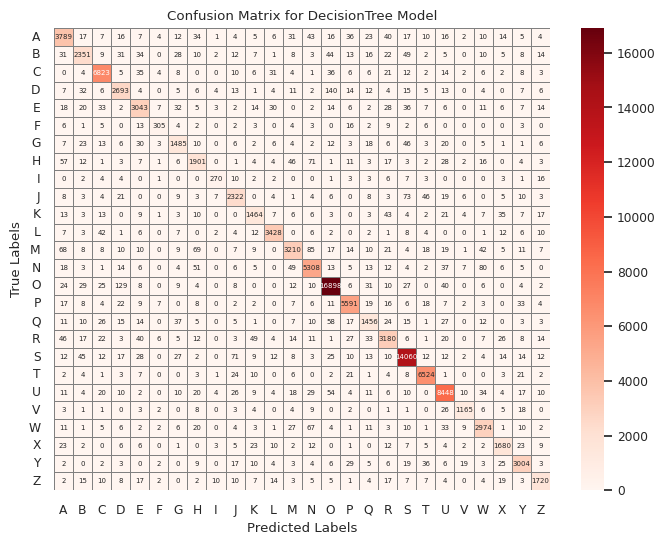

In [ ]:
# Heatmap of Confusion Matrix for DecisionTree algorithm
metrics(test = Y_test,pred = y_pred_dt,model="DecisionTree",show_confusion_matrix=True)


## Training Model Using RandomForest

In [10]:
# Importing RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [11]:
# Training Model using RandomForestClassifier
rf_gpu = RandomForestClassifier()
rf_gpu.fit(X_train_cpu,np.asarray(Y_train).ravel())


RandomForestClassifier()

In [ ]:
# Prediction Test data
y_pred_rf = rf_gpu.predict(X_test_cpu)


In [12]:
# Using pickle to save model
import pickle
with open("randomforest_model.pkl","wb") as f:
  pickle.dump(rf_gpu,f)

In [ ]:
# Checking for accuracy,Precision and Recall
metrics(test = Y_test,pred = y_pred_rf,model="RandomForest",score=True)


Accuracy of RandomForest Model is: 0.9833804682465812
Precision of RandomForest Model is: 0.9834130144451787
Recall of RandomForest Model is: 0.9833804682465812


In [ ]:
print(classification_report(Y_test,y_pred_rf,target_names=y_label))


              precision    recall  f1-score   support

           A       0.96      0.99      0.98      4169
           B       0.98      0.95      0.97      2715
           C       0.98      0.99      0.99      7049
           D       0.97      0.95      0.96      3008
           E       0.99      0.97      0.98      3348
           F       0.99      0.92      0.95       386
           G       0.98      0.94      0.96      1718
           H       0.98      0.94      0.96      2204
           I       1.00      0.94      0.97       338
           J       0.98      0.96      0.97      2565
           K       0.98      0.95      0.96      1681
           L       0.99      0.99      0.99      3564
           M       0.98      0.97      0.98      3662
           N       0.97      0.99      0.98      5649
           O       0.98      1.00      0.99     17282
           P       0.98      0.99      0.99      5802
           Q       0.98      0.93      0.95      1757
           R       0.99    

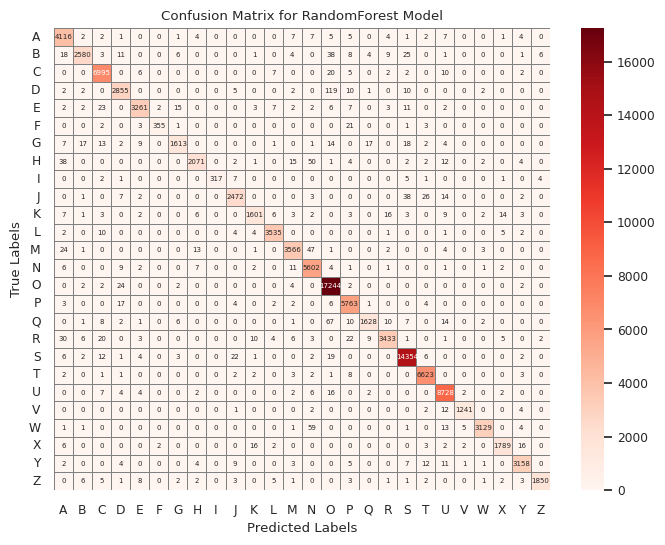

In [ ]:
# Heatmap of Confusion Matrix for RandomForest algorithm
metrics(test = Y_test,pred = y_pred_rf,model="RandomForest",show_confusion_matrix=True)


## Training Model using Logistic Regression

In [ ]:
# Importing LogisticRegression from cuml
from cuml.linear_model import LogisticRegression as lgr

In [ ]:
lr = lgr(multi_class="ovr")

[I] [11:26:36.526982] Unused keyword parameter: multi_class during cuML estimator initialization


In [ ]:
# Training model using LogisticRegression
lr.fit(X_train_cpu.astype("float32"),Y_train_le)


[W] [11:27:45.602350] L-BFGS: max iterations reached
[W] [11:27:45.603571] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


LogisticRegression()

In [ ]:
# Predicting test data
y_pred_lr = lr.predict(X_test)

In [ ]:
# Checking for accuracy,Precision and Recall
metrics(test = Y_test_le,pred = y_pred_lr,model="LogisticRegression",score=True)


Accuracy of LogisticRegression Model is: 0.87811448414119
Precision of LogisticRegression Model is: 0.877045148658403
Recall of LogisticRegression Model is: 0.87811448414119


In [ ]:
print(classification_report(Y_test_le,y_pred_lr,target_names=y_label))


              precision    recall  f1-score   support

           A       0.83      0.85      0.84      4169
           B       0.86      0.78      0.82      2715
           C       0.91      0.90      0.91      7049
           D       0.81      0.78      0.79      3008
           E       0.82      0.81      0.81      3348
           F       0.91      0.84      0.87       386
           G       0.84      0.76      0.80      1718
           H       0.77      0.70      0.73      2204
           I       0.89      0.83      0.86       338
           J       0.79      0.73      0.76      2565
           K       0.77      0.78      0.77      1681
           L       0.92      0.95      0.94      3564
           M       0.86      0.88      0.87      3662
           N       0.81      0.82      0.81      5649
           O       0.92      0.96      0.94     17282
           P       0.90      0.92      0.91      5802
           Q       0.85      0.75      0.80      1757
           R       0.82    

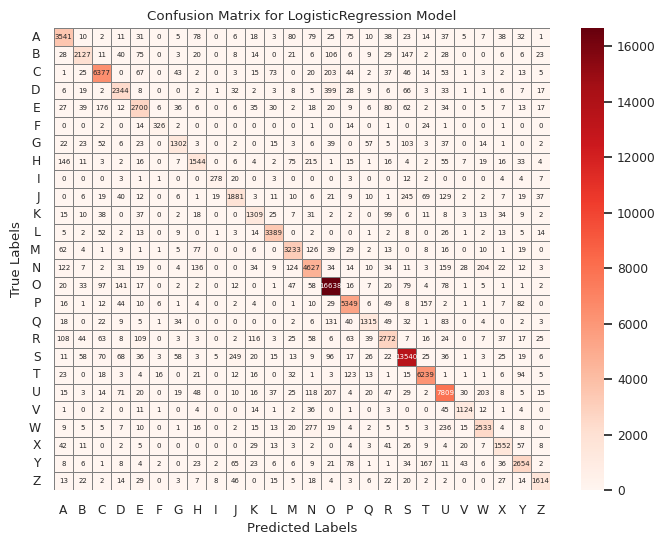

In [ ]:
# Heatmap of Confusion Matrix for LogisticRegression algorithm
metrics(test = Y_test_le,pred = y_pred_lr,model="LogisticRegression",show_confusion_matrix=True)


## Training Model using Naive Bayes

In [ ]:
# Importing MultinomialNB
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nb = MultinomialNB()

In [ ]:
# Training model using MultinomialNB
nb.fit(X_train,np.asarray(Y_train).ravel())

MultinomialNB()

In [ ]:
# Predicting Test data
y_pred_nb = nb.predict(X_test)

In [ ]:
# Checking for accuracy,Precision and Recall
metrics(test = Y_test,pred = y_pred_nb,model="Naive Bayes",score=True)


Accuracy of Naive Bayes Model is: 0.7002756497458295
Precision of Naive Bayes Model is: 0.7489761215791149
Recall of Naive Bayes Model is: 0.7002756497458295


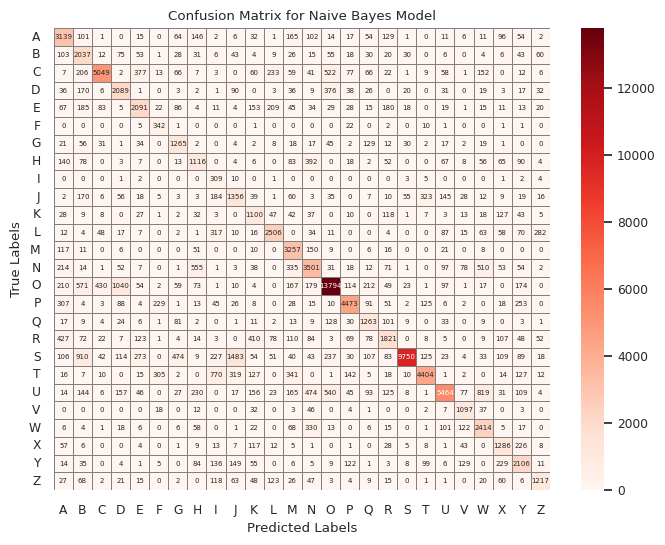

In [ ]:
# Heatmap of Confusion Matrix for Naive Bayes algorithm
metrics(test = Y_test,pred = y_pred_nb,model="Naive Bayes",show_confusion_matrix=True)


## Training Model using SVM

In [ ]:
# Importing SVC from cuml
# And Training model using SVC
from cuml import SVC
sv = SVC()
sv.fit(X_train.astype("float32"), Y_train_le)


SVC()

In [ ]:
# Predicting test data
sv_pred = sv.predict(X_test)


In [ ]:
# Using pickle to save model
import pickle
with open("svm_fitted_model.pkl","wb") as f:
  pickle.dump(sv,f)

In [ ]:
# Checking for accuracy,Precision and Recall
metrics(test = Y_test_le,pred = sv_pred,model="SVM",score=True)


Accuracy of SVM Model is: 0.9797558530822653
Precision of SVM Model is: 0.9797789500211048
Recall of SVM Model is: 0.9797558530822653


In [ ]:
print(classification_report(Y_test_le,sv_pred))


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4169
           1       0.98      0.96      0.97      2715
           2       0.98      0.98      0.98      7049
           3       0.94      0.95      0.94      3008
           4       0.98      0.97      0.97      3348
           5       0.98      0.96      0.97       386
           6       0.98      0.94      0.96      1718
           7       0.98      0.93      0.95      2204
           8       1.00      0.93      0.97       338
           9       0.96      0.96      0.96      2565
          10       0.96      0.95      0.95      1681
          11       0.98      0.99      0.98      3564
          12       0.98      0.98      0.98      3662
          13       0.97      0.98      0.98      5649
          14       0.98      0.99      0.99     17282
          15       0.98      0.99      0.99      5802
          16       0.97      0.93      0.95      1757
          17       0.98    

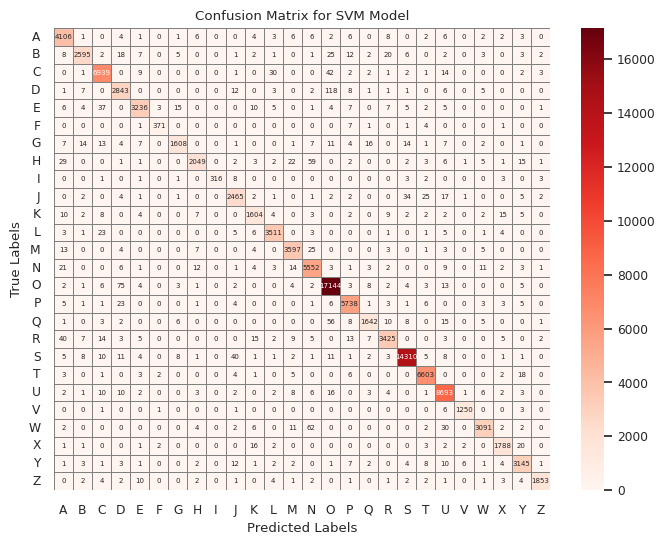

In [ ]:
# Heatmap of Confusion Matrix for SVC algorithm
metrics(test = Y_test_le,pred = sv_pred,model="SVM",show_confusion_matrix=True)


#Training Model using XGBoost Algorithm

In [ ]:
# Importing XGBClassifier
import xgboost as xgb
from xgboost import XGBClassifier


In [ ]:
# Running model on GPU
model_xgb = XGBClassifier(tree_method='gpu_hist')

In [ ]:
# Training model using XGBClassifier
model_xgb.fit(X_train,Y_train_le)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
# Prediction test data
xgb_predict = model_xgb.predict(X_test)

In [ ]:
# saving the model using pickle
import pickle
with open("xgboost_model.pkl","wb") as f:
  pickle.dump(model_xgb,f)

In [ ]:
# Checking for accuracy,Precision and Recall
metrics(test = Y_test_le,pred=xgb_predict,model="XGBoost",score=True)

Accuracy of XGBoost Model is: 0.9870050834108971
Precision of XGBoost Model is: 0.9870056107583386
Recall of XGBoost Model is: 0.9870050834108971


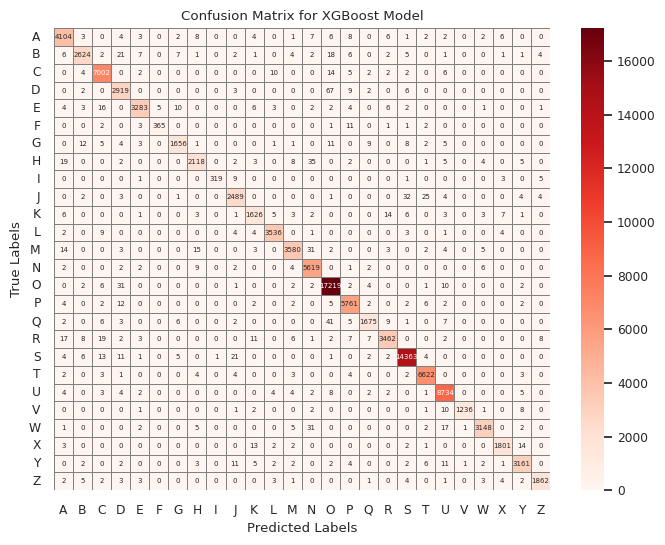

In [ ]:
# Heatmap of Confusion Matrix for XGBoost algorithm
metrics(test = Y_test_le,pred=xgb_predict,model="XGBoost",show_confusion_matrix=True)


# Comparing all Models

* Comparing all the models that are trained using different Algorithms

In [ ]:
# Creating DataFrame with accuracy, precision and recall
Best_Algo = {"Algorithm": ["KNN classifier"," DecisionTree Classifier","Randomforest classifier","LogisticRegression", "Naive Bayes Classifier",
                            "SVM","XGBoost"],
           "Accuracy": [95.68,94.05,98.33,87.82,70.02,97.97,98.7],
           "Precision":[95.77,94.03,98.34,87.7,74.89,97.97,98.7],
           "Recall":[95.68,94.05,98.33,87.8,70.02,97.97,98.7]}

In [ ]:
df_algo = pd.DataFrame(Best_Algo)
df_algo

,Algorithm,Accuracy,Precision,Recall
0,KNN classifier,95.68,95.77,95.68
1,DecisionTree Classifier,94.05,94.03,94.05
2,Randomforest classifier,98.33,98.34,98.33
3,LogisticRegression,87.82,87.70,87.80
4,Naive Bayes Classifier,70.02,74.89,70.02
5,SVM,97.97,97.97,97.97
6,XGBoost,98.70,98.70,98.70


In [ ]:
# Plotting Bar graph for Best Algorithm
fig = px.bar(y=df_algo["Algorithm"], x=df_algo["Accuracy"],color=df_algo["Algorithm"],hover_name=df_algo["Accuracy"],width=700, height=400,\
            labels={'y':'Algorithm',"x":"Accuracy"},title="Algorithm Vs Accuracy")
fig.show()

* From the above Plot we can see that XGBoost Outperformed all other Models.
* Naive Bayes is the worst algorithm for predicting Alphabets.
* SVM is very close to XGBoost in Predicting the data.


# Deploying XGBoost algorithm using Streamlit

In [ ]:
%%writefile mnist_pred.py
import numpy as np
import cv2
import pickle
import streamlit as st
from streamlit_drawable_canvas import st_canvas
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image


model = pickle.load(open("/content/xgboost_model.pkl", "rb"))

st.title('Alphabet Recognizer')
st.markdown('''
Write an Alphabet 
''')

SIZE = 192

# Create a canvas component
canvas_result = st_canvas(
    fill_color="#ffffff",  # Fixed fill color with some opacity
    stroke_width=10,
    stroke_color="#ffffff",
    background_color="#000000",
    height=150,
    width=150,
    drawing_mode='freedraw',
    key="canvas"
)

if canvas_result.image_data is not None:
    img = canvas_result.image_data
    img = Image.open(img)
    img = img.resize((28,28)).convert("L")
    img = np.array(img).flatten().tolist()
    st.image(img)
    

if st.button('Predict'):
    
    pred = model.predict(img[0])
    st.write(f"Result: {pred} ")
    


### Running streamlit app

In [ ]:
%%shell
streamlit run mnist_pred.py
